In [21]:
import numpy as np
from scipy.stats import truncnorm


class Layer(object):
  """層のクラス、親クラス"""
  def __init__(self, dim_input, dim_output, std=1., bias=0.):
    self.w = truncnorm(a=-2 * std, b=2 * std, scale=std).rvs((dim_input, dim_output)) #(dim_input, dim_output)
    self.b = np.ones(dim_output) * bias #(dim_out)

  def __call__(self, X):
    """順伝播"""
    self.input = X
    return self.forward_propagation(X)

  def back_propagation(self, delta, learning_rate):
    """逆伝搬
    :param delta: numpy.ndarray (num_data, dim_output)　誤差
    :param learning_rate: float 学習率
    :return delta: numpy.ndarray (num_data, dim_input)
    """
    delta = delta * self.activation_derivative() # (num_data, dim_output)
    w = np.copy(self.w)
    self.w -= learning_rate * np.dot(self.input.T, delta) #(dim_output, num_data)@(num_data, dim_input) = (dim_input, dim_output)
    self.b -= learning_rate * np.sum(delta, axis=0)

    return np.dot(delta, w.T) #(num_data, dim_out)@(dim_output, dim_input) = (num_data,dim_input)



class LinearLayer(Layer):
  def forward_propagation(self,X):
    """Linear-layer-class
    :param X: (num_data, input_dim)
    :return Ans: (num_data, output_dim)
    """
    return X@self.w + self.b #(num_data, dim_output) + (dim_output) ★
  
  def activation_derivative(self):
    return 1

class SigmoidLayer(Layer):
  def forward_propagation(self,X):
    """Sigmoid-layer-class
    :param X: (num_data, input_dim)
    :return Ans: (num_data, output_dim)
    """
    activ = X@self.w + self.b
    self.output = 1/(1 + np.exp(-activ))
    return self.output
  
  def activation_derivative(self):
    return self.output * (1 - self.output)

class SoftmaxLayer(Layer):
  def forward_propagation(self,X):
    """Softmax-layer-class
    :param X: (num_data, input_dim)
    :return Ans: (num_data, output_dim)
    """
    activ = np.exp(X@self.w + self.b) #(num_data, output_dim)
    self.output = activ / np.sum(activ, axis=1)
    return self.output
  
  def activation_derivative(self):
    tmp = self.output.reshape((-1,1)) #(num_data, output_dim,1)
    return np.diag(self.output) - np.outer(tmp,tmp)

class TanhLayer(Layer):
  """Tanh-layer-class
  :param X: (num_data, input_dim)
  :return Ans: (num_data, output_dim)
  """
  def forward_propagation(self, X):
    activation = X.dot(self.w) + self.b
    self.output = np.tanh(activation)
    return self.output

  def activation_derivative(self):
    return 1 - self.output ** 2 

class ReLULayer(Layer):
  def forward_propagation(self,X):
    """ReLU-layer-class
    :param X: (num_data, input_dim)
    :return Ans: (num_data, output_dim)
    """
    activation = X.dot(self.w) + self.b
    self.output = activation.clip(min=0)
    return self.output

  def activation_derivative(self):
    return (self.output > 0).astype(np.float)

class SigmoidCrossEntropy(object):
  def activate(self, logits):
    """Sigmoid-error-function
    :param logits: (num_data,dim_target) 
    :return Ans: (num_data, dim_target)
    """
    return 1/(1 + np.exp(-logits))

  def __call__(self, logits, targets):
    """Sigmoid-error-num
    :param logits: (num_data,dim_target=1) 
    :return Ans: float
    """
    probs = self.activate(logits)
    p = np.clip(probs, 1e-10, 1-1e-10)
    return np.sum(-targets * np.log(p) -(1-targets) * np.log(1-p))

  def delta(self, logits, targets):
    """Sigmoid-error-function-derivation
    :param logits: (num_data,dim_target=1) 
    :return Ans: (num_data, dim_target=1)
    """
    probs = self.activate(logits)
    return probs - targets

class SoftmaxCrossEntropy(object):
  def activate(self,logits):
    """Cross-entropy-function
    :param logits: (num_data, target_dim)
    :return Ans: (num_data, target_dim)
    """
    probs = logits / np.sum(logits, axis=1, keepdims=True) #(num_data, target_dim)/(num_data, 1) = (num_data, target_dim)
    return probs
  
  def __call__(self, logits, targets):
    """Cross-entropy-function
    :param logits: (num_data, target_dim)
    :return Ans: (num_data, target_dim)
    """
    probs = self.activate(logits) #(num_data, target_dim)
    return - np.sum(targets * np.log(probs)) #sum of (num_data, target_dim)@(target_dim, num_data)

  def delta(self, logits, targets):
    probs = self.activation(logits)
    return probs - targets

class SumSquaresError(object):

    def activate(self, X):
        return X

    def __call__(self, X, targets):
        return 0.5 * np.sum((X - targets) ** 2)

    def delta(self, X, targets):
        return X - targets

class NeuralNetwork(object):
  def __init__(self, layers, cost_function):
    """NeuralNetwork-Class
    :param layers: list of Layer's objects
    :param cost_functino: object of cost_function
    """
    self.layers = layers
    self.cost_function = cost_function

  def __call__(self,X):
    """順伝播"""
    for layer in self.layers:
      X = layer(X)

    return self.cost_function.activate(X)

  def fit(self, X, t, learning_rate):
    for layer in self.layers:
      X = layer(X)

    delta = self.cost_function.delta(X,t)
    for layer in reversed(self.layers):
      delta = layer.back_propagation(delta, learning_rate)

  def cost(self, X, t):
    for layer in self.layers:
      X = layer(X)
    return self.cost_function(X, t)


def create_toy_detaset(func, n=300):
  """データ設定"""
  t = np.random.uniform(size=(n,1))
  x = func(t) + np.random.uniform(-0.05, 0.05, size=(n,1))
  return x,t

def sample(x, t, n=None):
  """一つのミニバッチデータセットを返す"""
  assert len(x) == len(t)
  N = len(x)
  if n is None:
    n = N
  indices = np.random.choice(N, n ,replace=False)
  return x[indices], t[indices]


In [39]:
class GaussianMixture(object):
    """Negative Log Likelihood of Gaussian Mixture model"""
    def __init__(self, n_components):
        self.n_components = n_components

    def __call__(self, X, targets):
        sigma, weight, mu = self.activate(X)
        gauss = self.gauss(mu, sigma, targets)
        return -np.sum(np.log(np.sum(weight * gauss, axis=1)))

    def activate(self, X):
        assert np.size(X, 1) == 3 * self.n_components
        X_sigma, X_weight, X_mu = np.split(X, [self.n_components, 2 * self.n_components], axis=1)
        sigma = np.exp(X_sigma)
        weight = np.exp(X_weight - np.max(X_weight, 1, keepdims=True))
        weight /= np.sum(weight, axis=1, keepdims=True)
        return sigma, weight, X_mu

    def gauss(self, mu, sigma, targets):
        return np.exp(-0.5 * (mu - targets) ** 2 / np.square(sigma)) / np.sqrt(2 * np.pi * np.square(sigma))
    
    def delta(self, X, targets):
        sigma, weight, mu = self.activate(X)
        var = np.square(sigma)
        gamma = weight * self.gauss(mu, sigma, targets)
        gamma /= np.sum(gamma, axis=1, keepdims=True)

        delta_mu = gamma * (mu - targets) / var
        delta_sigma = gamma * (1 - (mu - targets) ** 2 / var)
        delta_weight = weight - gamma
        delta = np.hstack([delta_sigma, delta_weight, delta_mu])
        return delta



In [47]:
class GaussianMixture(object):
  """Negative log Likelihood of Gaussian Mixture NN model """
  def __init__(self, n_components):
    self.n_components = n_components

  def __call__(self, X, targets):
    sigma, weight, mu = self.activate(X)
    gauss = self.gauss(mu, sigma, targets)
    return -np.sum( np.log( np.sum( weight * gauss, axis=1)))

  def activate(self, X):
    """結果に変換する
    :param X: numpy.ndarray (num_data, 3*n_components)
    :return sigma: (num_data, n_components)
    :return wight: (num_data, n_components)
    :return X_mu: (num_data, n_components)
    """
    assert np.size(X,axis=1) == 3 * self.n_components
    X_sigma, X_weight, X_mu = np.split(X, [self.n_components, 2 * self.n_components], axis=1) #(num_data,n_components) (num_data, 2*n_components)
    sigma = np.exp(X_sigma)
    weight = np.exp(X_weight - np.max(X_weight, 1, keepdims=True)) #(num_data, n_components)
    weight /= np.sum(weight, axis=1, keepdims=True) #(num_data, n_components)
    return sigma, weight, X_mu


  def gauss(self, mu, sigma, targets):
    """ガウス関数を計算
    """
    return np.exp( -0.5 * (mu - targets) ** 2 / np.square(sigma)) / np.sqrt(2 * np.pi * np.square(sigma))

  def delta(self, X, targets):
    """微分して逆伝搬する

    :param X:(num_data, 3*n_components)
    :param target:(num_data, 1)
    :return delta:(num_data, 3*n_components)
    """
    sigma, weight, mu = self.activate(X) #(num_data, n)×３
    var = np.square(sigma)
    gamma = weight * self.gauss(mu,sigma, targets) #(num_data,n)
    gamma /= np.sum(gamma, axis=1, keepdims=True) #(num_data, 1)

    delta_mu = gamma * (mu - targets)/var #(num_data,1) * (num_data, n)/(num_data,n) = (num_data, n)
    delta_sigma = gamma * (1 - ((targets - mu)**2)/var)
    delta_weight = weight - gamma
    delta = np.hstack([delta_sigma, delta_weight, delta_mu])
    return delta
  

In [48]:
def func(x):
  return x + 0.3 * np.sin(2 * np.pi* x)

x,t = create_toy_detaset(func)

layers = [TanhLayer(1,5,std=0.1), LinearLayer(5,9,std=0.1)]
cost_function = GaussianMixture(3)
nn = NeuralNetwork(layers, cost_function)
learning_rate = 10e-4
for i in range(500000):
  if i % 10000 == 0:
    print(f"step:{i}, score:{nn.cost(x,t)}")
    learning_rate *= 0.9
  batch = sample(x,t,n=100)
  nn.fit(*batch, learning_rate=learning_rate)

x_test = np.linspace(x.min(), x.max(), 100)
y_test = np.linspace(t.min(), t.max(), 100)
X_test, Y_test = np.meshgrid(x_test, y_test)
test = np.array([X_test, Y_test]).transpose((1,2,0)).reshape(-1,2)

sigma, weight, mu = nn(test[:,0].reshape(-1,1))
probs = cost_function.gauss(mu, sigma, test[:,1].reshape(-1,1)) #(num_data, 3)
probs = np.sum(weight * probs, axis=1)
Probs = probs.reshape(100,100)

step:0, score:326.42318631560204
step:10000, score:-126.98927423529099
step:20000, score:-65.62422652418226
step:30000, score:-32.925355933225674
step:40000, score:-59.2961557289349
step:50000, score:-30.488191866023207
step:60000, score:-68.89980001683438
step:70000, score:-81.97783777319361
step:80000, score:-96.0651517912392
step:90000, score:-165.73408484835466
step:100000, score:-167.4673269280566
step:110000, score:-146.3040100231451
step:120000, score:-93.6595620872379
step:130000, score:-231.8154208443342
step:140000, score:-241.87320736906503
step:150000, score:-262.1798165818933
step:160000, score:-208.39575049428637
step:170000, score:-235.59261640347393
step:180000, score:-219.06735570530225
step:190000, score:-280.3003699695702
step:200000, score:-301.3601673908303
step:210000, score:-303.9165930324902
step:220000, score:-197.27619316575695
step:230000, score:-314.6786684205372
step:240000, score:-319.0244426360263
step:250000, score:-191.92862050939698
step:260000, score:

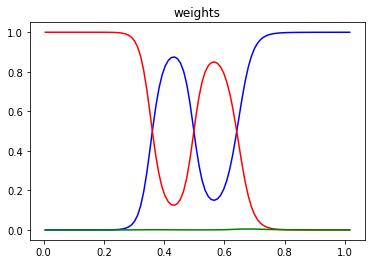

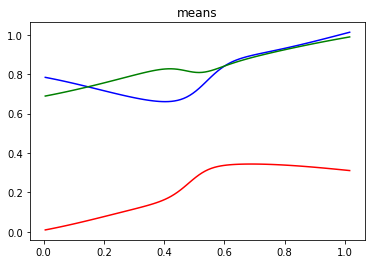

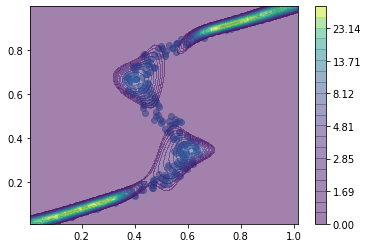

In [49]:
    plt.plot(x_test, weight[:100, 0], color="blue")
    plt.plot(x_test, weight[:100, 1], color="red")
    plt.plot(x_test, weight[:100, 2], color="green")
    plt.title("weights")
    plt.show()

    plt.plot(x_test, mu[:100, 0], color="blue")
    plt.plot(x_test, mu[:100, 1], color="red")
    plt.plot(x_test, mu[:100, 2], color="green")
    plt.title("means")
    plt.show()

    plt.scatter(x, t, alpha=0.5, label="observation")
    levels_log = np.linspace(0, np.log(probs.max()), 21)
    levels = np.exp(levels_log)
    levels[0] = 0
    plt.contourf(X_test, Y_test, Probs, levels, alpha=0.5)
    plt.colorbar()
    plt.xlim(x.min(), x.max())
    plt.ylim(t.min(), t.max())
    plt.show()
